# Project 4: Predicting Outbreaks of West Nile Virus in Chicago

Group 2 Joint Submission: Derrick Hoe, Joyce Ooi, Nee Bimin, Cheong Yu Chye

## Notebook 1: Data Cleaning and EDA

This notebook contains the Problem Statement and code for data cleaning and EDA.

### Contents

- [Problem Statement](#Problem-Statement)
- [Executive Summary](#Executive-Summary)
- [Importing of Libraries](#Importing-of-Libraries)
- [Data Import](#Data-Import)
- [Preliminary Analysis and Data Cleaning](#Preliminary-Analysis-and-Data-Cleaning)
- [Data Cleaning and EDA](#Cleaning-and-EDA-for-Training-Dataset)
    * [Training Dataset](#Training-Dataset)
    * [Weather Dataset](#Merge-Weather-Dataset)
    * [Spray Dataset](#Spray-Dataset)
- [Data Export](#Data-Export)

## Problem Statement

To train a classifier to predict when and where different species of mosquitos will test positive for West Nile Virus (WNV). WNV is most commonly spread to humans through infected mosquitos. Around 20% of people who become infected with the virus develop symptoms ranging from a persistent fever, to serious neurological illnesses that can result in death.

A more accurate method of predicting outbreaks of West Nile virus in mosquitos will help the City of Chicago and CPHD more efficiently and effectively allocate resources towards preventing transmission of this potentially deadly virus. 

Success will be evaluated via the area under the receiver operating curve (ROC) and sensitivity:
- ROC is a probability curve and area under the curve (AUC) represents the degree or measure of separability. It tells how much a model is capable of distinguishing between classes. The higher the AUC, the better the model is at predicting 0s as 0s and 1s as 1s. In this context, the higher the AUC, the better the model is at distinguishing between whether the virus is present or not present. This metric is chosen because of the imbalanced data that we have. Purposefully optimising evaluation metrics is one of the ways to deal with imbalanced data.
- Sensitivity measures the proportion of actual positives that are correctly identified as such - in this case, it measures the proportion of mosquitos predicted to test positive for WNV that are correctly identified as such. This recognises the need to reduce false negatives so that the authorities can be more conservative in their mosquito control measures.

## Executive Summary

Around 20% of people who become infected with the virus develop symptoms ranging from a persistent fever, to serious neurological illnesses that is prolonged and even death. The datasets are obtained from Kaggle: https://www.kaggle.com/c/predict-west-nile-virus/data.

There are the train, test, weather and spray datasets. The train and test sets were processed similarly, by removing the address, block and street since latitude and longitude suffice in capturing information on location. Nummosquitoes were also removed from the train set since it does not exist in the test set. Much of the cleaning effort went into the weather dataset where missing and trace values were imputed. Four variables - wetbulb, tavg, dewpoint, preciptotal - were ultimately chosen from the weather dataset and were feature engineered into our test and train sets. They were chosen based on an article found here: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3774453/, which details the environmental drivers of the virus. Feature-engineering of some of the variables were done to handle the correlation between the variables tavg, dewpoint and wetbulb.

We applied the SMOTE technique to make up for the very unbalanced dataset, with approximately 94.8% from class 0 (West Nile Virus not present). Classifier models - K-nearest Neighbours, Logistic Regression, Extra Trees, Random Forests, Decision Trees and ADA Boost with hyperparameter tuning conducted via randomised search.

The model that was found to be of the highest ROC AUC score is Logistic Regression. We observe minimal overfitting of the model when comparing both the accuracy and AUC scores of the training and validation datasets.

Besides having the highest ROC-AUC score among the models run, the Logistic Regression model has the highest sensitivity of 0.650794, which is an important metric in this case. This means that 65% of wnvpresent cases were identified correctly. False negatives need to be reduced so that mosquito control measures can be done at all areas which have the virus.

## Importing of Libraries

In [1]:
# Read in libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import scipy.stats as stats
from mpl_toolkits import mplot3d
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import ensemble, preprocessing
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline 

C:\Users\yuchy\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data Import

In [2]:
# Import data from downloaded csv files
train = pd.read_csv('../assets/train.csv')
test = pd.read_csv('../assets/test.csv')
spray = pd.read_csv('../assets/spray.csv')
weather = pd.read_csv('../assets/weather.csv')

## Preliminary Analysis and Data Cleaning

In [3]:
train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [4]:
test.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


In [5]:
spray.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [6]:
weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


M stands for missing data. We can see quite a number of missing data here especially for Depart, Water1, SnowFall and Depth.

In [7]:
# Convert all the date columns to datetime data type
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])
spray['Date'] = pd.to_datetime(spray['Date'])
weather['Date'] = pd.to_datetime(weather['Date'])

In [8]:
# Change column headers to lowercase
train.columns = [x.lower() for x in train.columns]
test.columns = [x.lower() for x in test.columns]
spray.columns = [x.lower() for x in spray.columns]
weather.columns = [x.lower() for x in weather.columns]

In [9]:
print('Train set missing values:\n', train.isnull().sum(), '\n')
print('Test set missing values:\n', test.isnull().sum(), '\n')
print('Spray set missing values:\n', spray.isnull().sum(), '\n')
print('Weather set missing values:\n', weather.isnull().sum(), '\n')

Train set missing values:
 date                      0
address                   0
species                   0
block                     0
street                    0
trap                      0
addressnumberandstreet    0
latitude                  0
longitude                 0
addressaccuracy           0
nummosquitos              0
wnvpresent                0
dtype: int64 

Test set missing values:
 id                        0
date                      0
address                   0
species                   0
block                     0
street                    0
trap                      0
addressnumberandstreet    0
latitude                  0
longitude                 0
addressaccuracy           0
dtype: int64 

Spray set missing values:
 date           0
time         584
latitude       0
longitude      0
dtype: int64 

Weather set missing values:
 station        0
date           0
tmax           0
tmin           0
tavg           0
depart         0
dewpoint       0
wetbulb        

At first glance, the training and testing datasets are clean, without missing values. We will be cleaning each of the datasets next. 

## Data Cleaning and EDA

### Training Dataset

In [10]:
# Function to getting some basic information about each dataframe
# shape of dataframe i.e. number of rows and columns
# total number of rows with null values
# total number of duplicates
# data types of columns

def basic_eda(df, df_name):
    print(df_name.upper())
    print()
    print(f"Rows: {df.shape[0]} \t Columns: {df.shape[1]}")
    print()
    
    print(f"Total null rows: {df.isnull().sum().sum()}")
    print(f"Percentage null rows: {round(df.isnull().sum().sum() / df.shape[0] * 100, 2)}%")
    print()
    
    print(f"Total duplicate rows: {df[df.duplicated(keep=False)].shape[0]}")
    print(f"Percentage dupe rows: {round(df[df.duplicated(keep=False)].shape[0] / df.shape[0] * 100, 2)}%")
    print()
    
    print(df.dtypes)
    print("-----\n")

In [11]:
basic_eda(train, 'train')

TRAIN

Rows: 10506 	 Columns: 12

Total null rows: 0
Percentage null rows: 0.0%

Total duplicate rows: 1062
Percentage dupe rows: 10.11%

date                      datetime64[ns]
address                           object
species                           object
block                              int64
street                            object
trap                              object
addressnumberandstreet            object
latitude                         float64
longitude                        float64
addressaccuracy                    int64
nummosquitos                       int64
wnvpresent                         int64
dtype: object
-----



#### Identification and removal of duplicate rows

In [12]:
# Check if there are any more duplicate rows
train[train.duplicated(keep=False)].shape[0]

1062

We note that there are duplicate rows in the training dataset, which need to be removed.

In [13]:
# Determine how many rows exist before removal of the duplicates
train.shape[0]

10506

In [14]:
train.drop_duplicates(keep='first', inplace=True)

In [15]:
# Check if there are any more duplicate rows
train[train.duplicated(keep=False)].shape[0]

0

In [16]:
# Show how many unique rows remain
train.shape[0]

9693

#### Analysis of species type

In [17]:
print(f'number of species: {train["species"].nunique()}')
train["species"].value_counts(normalize=True)

number of species: 7


CULEX PIPIENS/RESTUANS    0.461054
CULEX RESTUANS            0.275663
CULEX PIPIENS             0.230991
CULEX TERRITANS           0.022800
CULEX SALINARIUS          0.008769
CULEX TARSALIS            0.000619
CULEX ERRATICUS           0.000103
Name: species, dtype: float64

We can see that culex pipiens / restuans make up  more than 96% of the species sampled.

#### Analysis of WNV infection by species type

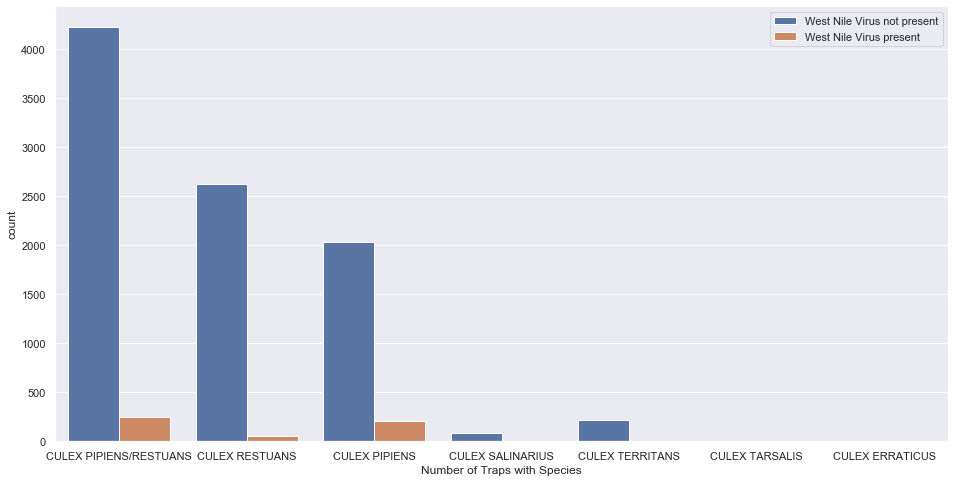

In [18]:
# We plot a countplot
sns.set(font_scale=1)
sns.set(rc={'figure.figsize':(16,8)})
sns.countplot(x='species', hue='wnvpresent', data=train)
plt.xticks(rotation=0)
plt.legend(['West Nile Virus not present', 'West Nile Virus present'], loc=1)
plt.xlabel('Number of Traps with Species')
plt.show();

                        nummosquitos  wnvpresent
species                                         
CULEX ERRATICUS                    7           0
CULEX PIPIENS                  23238         208
CULEX PIPIENS/RESTUANS         53691         246
CULEX RESTUANS                 21376          49
CULEX SALINARIUS                 144           0
CULEX TARSALIS                     7           0
CULEX TERRITANS                  508           0


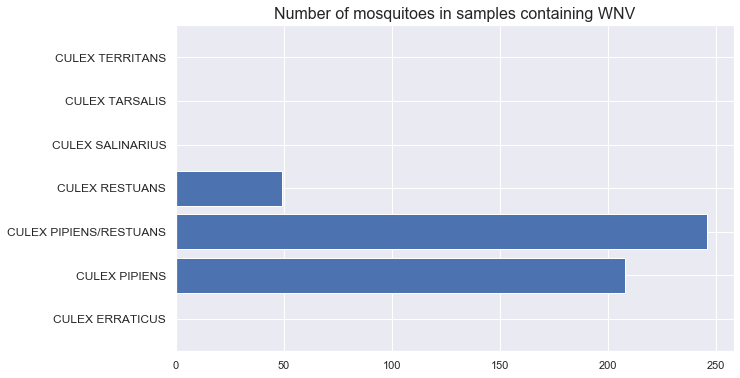

In [19]:
mos_wnv = train[['species', 'nummosquitos', 'wnvpresent']].groupby(by='species').sum()
print(mos_wnv)
mos_wnv.reset_index(inplace=True)
plt.figure(figsize=(10,6))
plt.barh(mos_wnv['species'], mos_wnv['wnvpresent'])
plt.title('Number of mosquitoes in samples containing WNV', fontsize=16)
plt.yticks(fontsize=12)
plt.show()

We can see above that WNV is only present in the following 3 species of mosquitos:
- Culex Pipiens/Restuans
- Culex Restuans 
- Culex Pipiens

#### Analysis of average number of mosquitos in traps according to month 

In [20]:
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
train['year'] = train['date'].dt.year

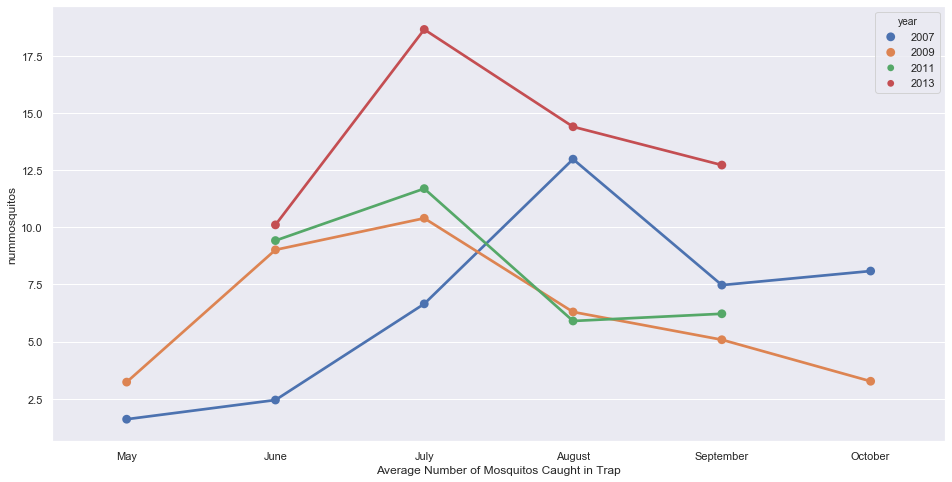

In [21]:
_ = sns.pointplot(x='month', y="nummosquitos", hue="year", data=train.groupby(['year', 'month'], as_index=False)['nummosquitos'].mean(),)
_.set(xticklabels=['May', 'June', 'July', 'August', 'September', 'October'])
plt.xlabel('Average Number of Mosquitos Caught in Trap');

We see above that the peak of approx. 20 mosquitos is around August for 2007 and July in 2013.

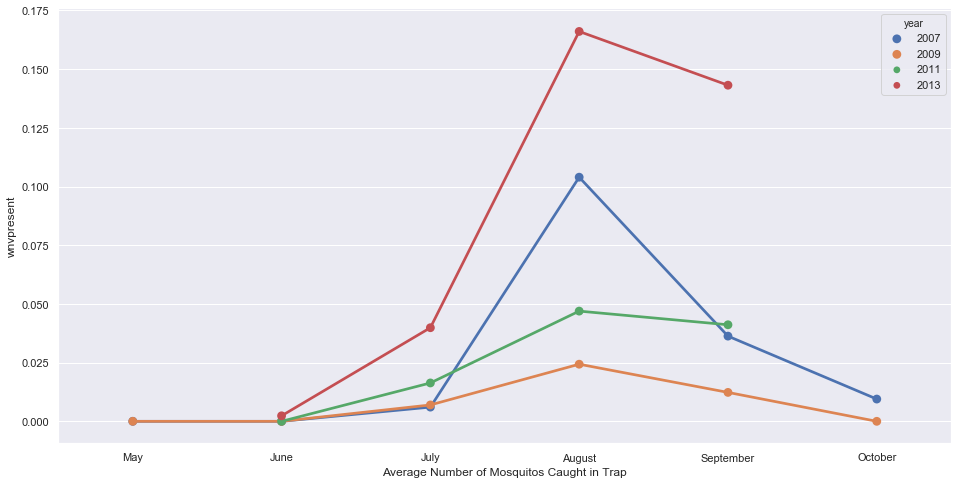

In [22]:
_ = sns.pointplot(x='month', y="wnvpresent", hue="year", data=train.groupby(['year', 'month'], as_index=False)['wnvpresent'].mean(),)
_.set(xticklabels=['May', 'June', 'July', 'August', 'September', 'October'])
plt.xlabel('Average Number of Mosquitos Caught in Trap');

We see above that the average number of WNV-infected mosquitoes caught in traps peaks in August for all the years.

#### Analysis of trap locations

In [23]:
train.columns

Index(['date', 'address', 'species', 'block', 'street', 'trap',
       'addressnumberandstreet', 'latitude', 'longitude', 'addressaccuracy',
       'nummosquitos', 'wnvpresent', 'month', 'day', 'year'],
      dtype='object')

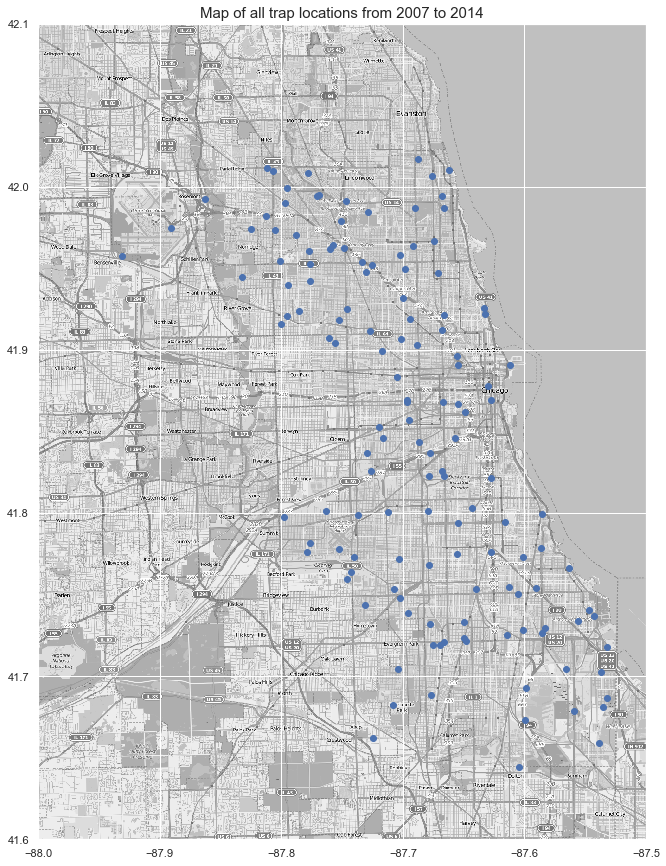

In [24]:
mapdata = np.loadtxt("../assets/mapdata_copyright_openstreetmap_contributors.txt")
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(15,15))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

locations = train[['longitude', 'latitude']].drop_duplicates().values
plt.scatter(locations[:,0], locations[:,1], marker='o', c='b')
plt.title("Map of all trap locations from 2007 to 2014", fontsize=15);

T900     612
T115     212
T138     181
T135     172
T002     168
        ... 
T238       7
T076       5
T094B      5
T237       3
T040       2
Name: trap, Length: 136, dtype: int64


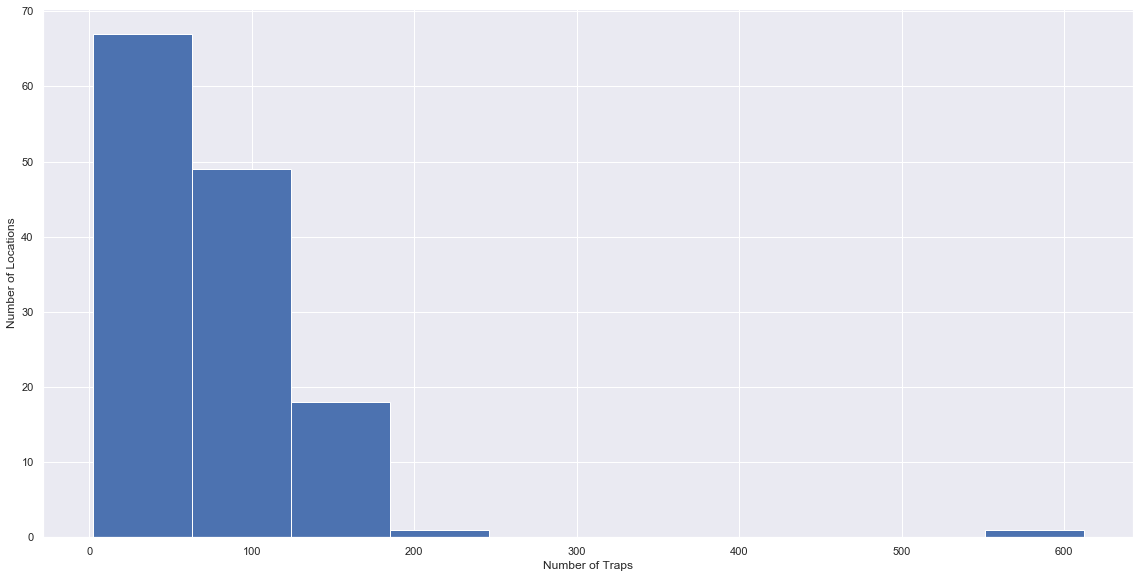

In [25]:
print(train.trap.value_counts())
train.trap.value_counts().plot(kind='hist')
plt.tight_layout()
plt.xticks(rotation=0)
plt.xlabel('Number of Traps')
plt.ylabel('Number of Locations');

We see above that there are a total of 136 trap locations and that T900 refers to the location (at Ohare airport) which has the most number of traps at 750.

#### Analysis of distribution of number of mosquitoes

In [26]:
# distribution plots (histogram, boxplot, probplot)
def dist_plots(df, list_of_columns):
    nrows = len(list_of_columns)
    fig, ax = plt.subplots(nrows = nrows, ncols = 3, figsize=(15, nrows*3.5))
    ax = ax.ravel()
    for i, col in enumerate(list_of_columns):
        sns.distplot(df[col], ax = ax[i*3-3], fit = stats.norm)
        ax[i*3-3].set_title(f'{col} distribution plot',fontsize=14)
        ax[i*3-3].tick_params(labelsize=12)
        ax[i*3-3].set_xlabel(col, fontsize=14)
        
        sns.boxplot(df[col], width = 0.2, ax = ax[i*3-2])
        ax[i*3-2].set_title(f'{col} box plot',fontsize=14)
        ax[i*3-2].tick_params(labelsize=12)
        ax[i*3-2].set_xlabel(col, fontsize=14)
        
        stats.probplot(df[col], plot = ax[i*3-1])
        ax[i*3-1].set_title(f'{col} probability plot', fontsize=14)
        ax[i*3-1].tick_params(labelsize=12)
        ax[i*3-1].set_xlabel(col, fontsize=14)
    plt.tight_layout()

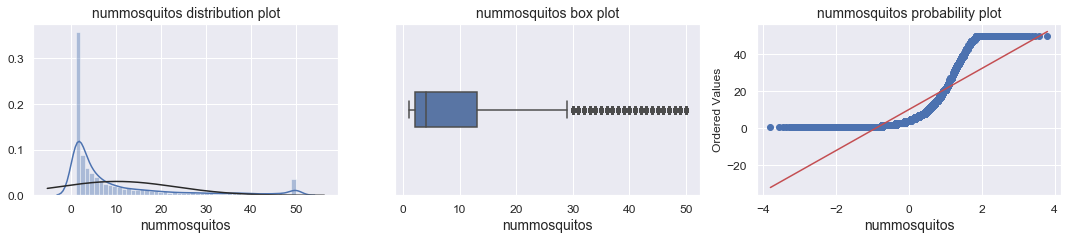

In [27]:
dist_plots(train, ['nummosquitos'])

We can see that, based on the distribution plot and box plot of the number of mosquitoes, there are quite a number of outliers. The probability plot plots sample data against the quantiles of a normal distribution. The red line is the best-fit line for the data. As the plotted line does not appear to follow the best-fit line closely, we infer that the number of mosquitoes does not follow a normal distribution.

#### Analysis of mosquito clusters and outliers (based on location)

In [28]:
#Formula for DBSCAN for clustering

def dbscan(df, list_of_columns, eps, min_samples):
    
    df_cluster = df[list_of_columns]

    minmax = MinMaxScaler(feature_range = (0, 1))

    clusters = minmax.fit_transform(df_cluster)

    dbs = DBSCAN(eps = eps, min_samples = min_samples)
    dbs.fit(clusters)
    df['cluster'] = dbs.labels_
    vals = df['cluster'].value_counts()
    print(f'Silhouette Score: {silhouette_score(clusters, dbs.labels_)}')
    print(f'Number of outliers: {vals[-1]} ({vals[-1] * 100 / len(df):.2f}% of samples)')
    print(f'Number of clusters: {len(vals)}')

    fig = plt.figure(figsize = (20, 16))
    ax = plt.axes(projection = '3d')
    ax.scatter3D(df['latitude'], df['longitude'], df['nummosquitos'], c = df['cluster'], cmap = 'rainbow')
    ax.set_title(f'DBSCAN for {list_of_columns}\n\u03B5 = {eps} Min. Clusters = {min_samples}')
    plt.show()

In [29]:
#We will create a Coordinates column out of Latitude and longitude
train['coord'] = [(x, y) for x, y in zip(train['latitude'], train['longitude'])]
#We create another dataframe to groupby Date and Coordinates by mean
train_cluster = train.groupby(['date', 'coord']).mean().copy()
train_cluster.head()

block   latitude  longitude  \
date       coord                                                  
2007-05-29 (41.688324, -87.676709)   22.0  41.688324 -87.676709   
           (41.720848, -87.666014)   17.0  41.720848 -87.666014   
           (41.731922, -87.677512)   22.0  41.731922 -87.677512   
           (41.732984, -87.649642)   89.0  41.732984 -87.649642   
           (41.862292, -87.64886)    11.0  41.862292 -87.648860   

                                    addressaccuracy  nummosquitos  wnvpresent  \
date       coord                                                                
2007-05-29 (41.688324, -87.676709)              8.0           1.0         0.0   
           (41.720848, -87.666014)              9.0           3.0         0.0   
           (41.731922, -87.677512)              8.0           3.0         0.0   
           (41.732984, -87.649642)              8.0           1.0         0.0   
           (41.862292, -87.64886)               8.0           1.0         0.0   

                                    month   day    year  
date       coord                                         
2007-05-29 (41.688324, -87.676709)    5.0  29.0  2007.0  
           (41.720848, -87.666014)    5.0  29.0  2007.0  
           (41.731922, -87.677512)    5.0  29.0  2007.0  
           (41.732984, -87.649642)    5.0  29.0  2007.0  
           (41.862292, -87.64886)     5.0  29.0  2007.0

Silhouette Score: -0.14182294208471666
Number of outliers: 282 (6.11% of samples)
Number of clusters: 58


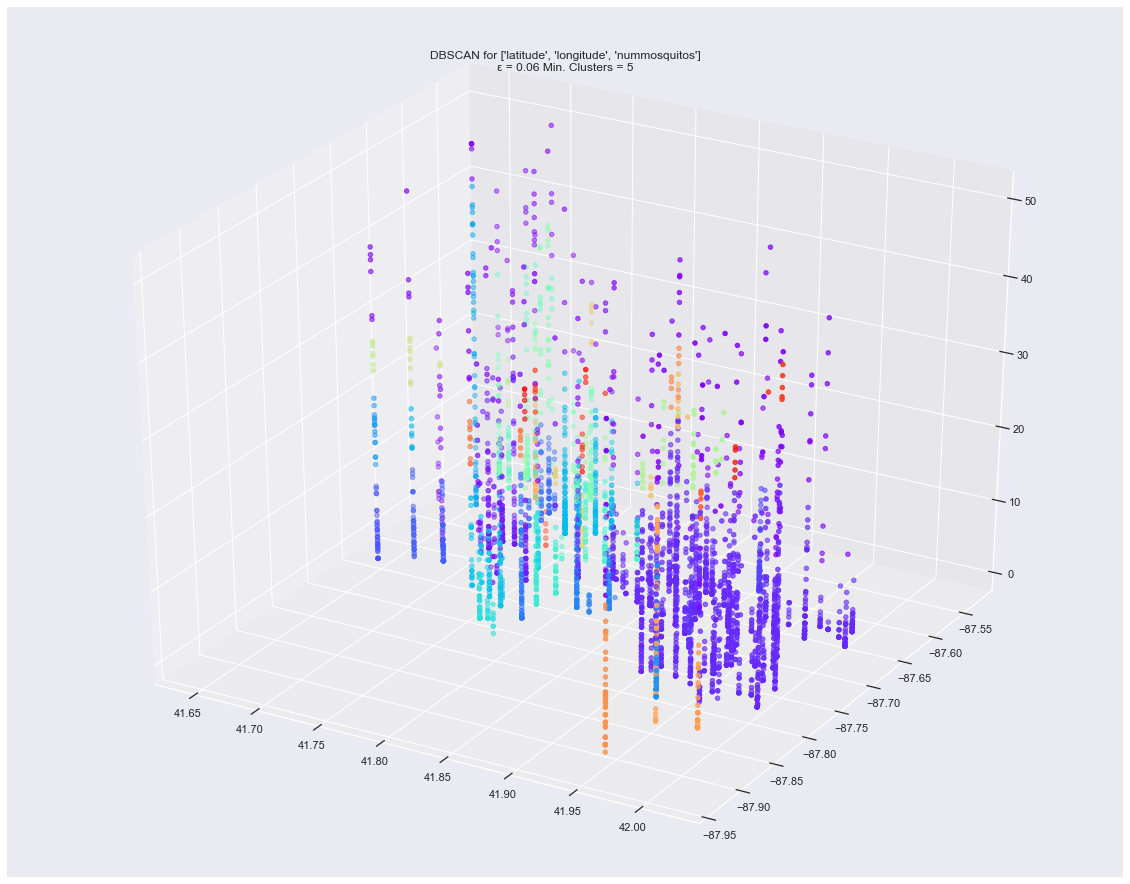

In [30]:
#eps: specifies how close points should be to each other to be considered a part of a cluster. 
#It means that if the distance between two points is lower or equal to this value (eps), these points are considered neighbors.
#minPoints: the minimum number of points to form a dense region. 
#For example, if we set the minPoints parameter as 5, then we need at least 5 points to form a dense region.

dbscan(train_cluster, ['latitude', 'longitude', 'nummosquitos'], eps = 0.06, min_samples = 5)

#### Further analysis of mosquito clusters

In [31]:
# We create a group of cluster based on the mean of coordinates and clusters.
cluster_group_mean = train_cluster.groupby(['coord', 'cluster']).mean()
# We create another group of cluster based on duplicates and outliers. 
cluster_duplicated = cluster_group_mean.index.get_level_values('coord').duplicated(keep = False)
cluster_outliers = (cluster_group_mean.index.get_level_values('cluster') == -1)

In [32]:
# We create a dataframe that is grouped by the mean of the clusters and coordinates
# Checking for LatLongs that belong to more than 1 cluster, we dont want to look at those that are by themselves.
cluster_group_mean.loc[cluster_duplicated]#Looking at clusterings.

block   latitude  longitude  \
coord                           cluster                                
(41.659112, -87.53869300000001) -1        40.0  41.659112 -87.538693   
                                 25       40.0  41.659112 -87.538693   
                                 27       40.0  41.659112 -87.538693   
(41.662014, -87.72460799999999) -1        42.0  41.662014 -87.724608   
                                 5        42.0  41.662014 -87.724608   
...                                        ...        ...        ...   
(42.009876, -87.807277)          2        71.0  42.009876 -87.807277   
(42.011601, -87.81150600000001) -1        72.0  42.011601 -87.811506   
                                 2        72.0  42.011601 -87.811506   
(42.01743, -87.68776899999999)  -1        75.0  42.017430 -87.687769   
                                 2        75.0  42.017430 -87.687769   

                                         addressaccuracy  nummosquitos  \
coord                           cluster                                  
(41.659112, -87.53869300000001) -1                   8.0     30.408333   
                                 25                  8.0     25.875000   
                                 27                  8.0      5.053571   
(41.662014, -87.72460799999999) -1                   8.0     38.938889   
                                 5                   8.0      4.292793   
...                                                  ...           ...   
(42.009876, -87.807277)          2                   9.0      8.818841   
(42.011601, -87.81150600000001) -1                   8.0     38.000000   
                                 2                   8.0      7.405952   
(42.01743, -87.68776899999999)  -1                   8.0     13.500000   
                                 2                   8.0      2.518519   

                                         wnvpresent     month        day  \
coord                           cluster                                    
(41.659112, -87.53869300000001) -1         0.270833  7.333333  19.833333   
                                 25        0.000000  8.000000  11.500000   
                                 27        0.031746  7.738095  17.690476   
(41.662014, -87.72460799999999) -1         0.066667  7.166667  13.500000   
                                 5         0.000000  7.621622  16.378378   
...                                             ...       ...        ...   
(42.009876, -87.807277)          2         0.057971  7.869565  16.217391   
(42.011601, -87.81150600000001) -1         0.625000  8.000000  11.000000   
                                 2         0.035714  7.428571  16.500000   
(42.01743, -87.68776899999999)  -1         0.000000  7.000000  11.000000   
                                 2         0.000000  7.250000  17.222222   

                                                year  
coord                           cluster               
(41.659112, -87.53869300000001) -1       2012.000000  
                                 25      2013.000000  
                                 27      2010.047619  
(41.662014, -87.72460799999999) -1       2009.333333  
                                 5       2009.972973  
...                                              ...  
(42.009876, -87.807277)          2       2012.304348  
(42.011601, -87.81150600000001) -1       2007.000000  
                                 2       2008.000000  
(42.01743, -87.68776899999999)  -1       2011.000000  
                                 2       2008.388889  

[216 rows x 9 columns]

We now plot a scatter plot on the above dataframe to look at the number of mosquitoes across per year according to different blocks and the presence of WNV.

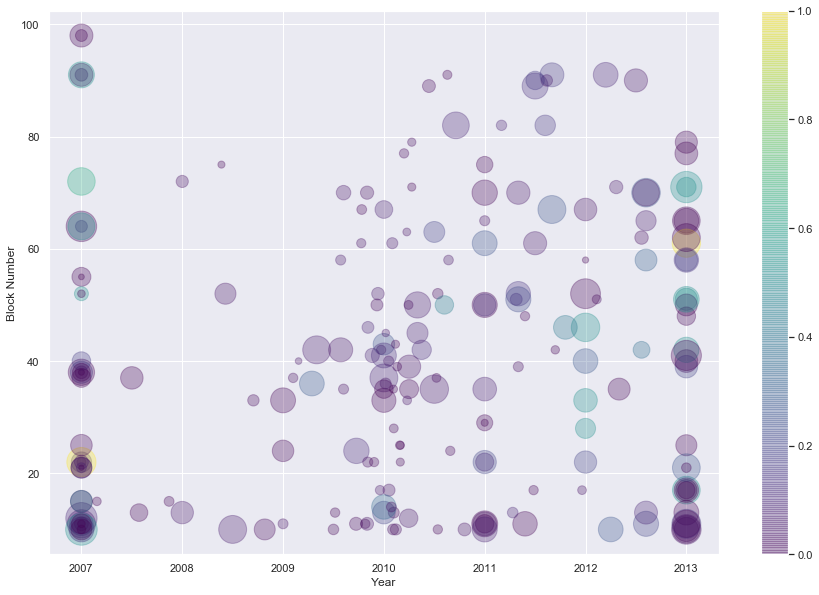

In [33]:
#Color represents the presence of WNV illness
#Purple colors signifies 0.0 while yellow signifies 1.0 for wnvpresent = 1
colors = cluster_group_mean.loc[cluster_duplicated]['wnvpresent']
#Size signifies the number of mosquitoes, the larger the size, the more the mosquitos get caught.
sizes = 20 * cluster_group_mean.loc[cluster_duplicated]['nummosquitos']
#We will plot a scatter plot based on the clusters above.
fig = plt.figure(figsize = (15, 10))
plt.scatter(x='year', y='block', data=cluster_group_mean.loc[cluster_duplicated], c=colors, s=sizes, alpha=0.3,cmap='viridis')
plt.xlabel('Year')
plt.ylabel('Block Number')
plt.colorbar();

|S/N|Label|Description|
|---|:--|:--|
|1|Color|Signifies the presence of West Niles Virus where purple indicates 0.0 and yellow indicates 1.0|
|2|Sizes|Sizes of the mosquitos represent the number of mosquitoes gettings caught|
|3|Y label|Block Number|
|4|X label|Year|

#### Summary of findings based on mosquito clusters

- We observe that there are more mosquitoes and WNV-infected mosquitoes caught in 2007, compared to other years.
- Towards 2008 and 2009, there appears to be a lack of attempts to catch these mosquitoes.
- More traps were set at different blocks across 2010 and 2013, compared to 2008 and 2009.
- In 2013 alone, we observe that overall, there were more mosquitoes at the different blocks and more WNV-infected mosquitoes were getting caught as well.
- It appears that WNV infections increased significantly again at 2013 since the period of 2007.

#### Further analysis of outliers (i.e. mosquitoes caught that were not in any clusters)

In [34]:
cluster_group_mean.loc[cluster_outliers] 
#Since we are grouping them by mean, they are just by itself so the mean value would just be by themself.

,,block,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent,month,day,year
coord,cluster,,,,,,,,,
"(41.644612, -87.60449799999999)",-1,82.0,41.644612,-87.604498,5.0,6.833333,0.055556,8.444444,10.222222,2007.000000
"(41.659112, -87.53869300000001)",-1,40.0,41.659112,-87.538693,8.0,30.408333,0.270833,7.333333,19.833333,2012.000000
"(41.662014, -87.72460799999999)",-1,42.0,41.662014,-87.724608,8.0,38.938889,0.066667,7.166667,13.500000,2009.333333
"(41.673408, -87.599862)",-1,12.0,41.673408,-87.599862,5.0,48.946667,0.106667,8.400000,14.800000,2007.000000
"(41.678618, -87.559308)",-1,13.0,41.678618,-87.559308,5.0,25.087500,0.062500,7.500000,18.000000,2008.000000
...,...,...,...,...,...,...,...,...,...,...
"(41.992478000000006, -87.862995)",-1,91.0,41.992478,-87.862995,8.0,28.712963,0.157407,7.333333,16.777778,2011.666667
"(42.008314, -87.77792099999999)",-1,70.0,42.008314,-87.777921,9.0,35.760000,0.000000,7.400000,11.200000,2012.600000
"(42.009876, -87.807277)",-1,71.0,42.009876,-87.807277,9.0,49.166667,0.500000,8.000000,18.500000,2013.000000


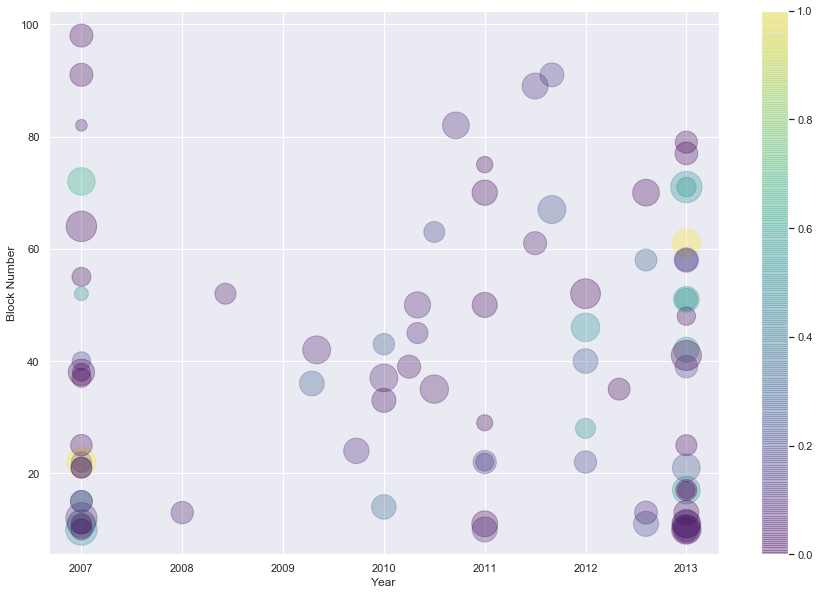

In [35]:
#Color represents the presence of WNV illness
#Purple colors signifies 0.0 while yellow signifies 1.0 for wnvpresent = 1
colors = cluster_group_mean.loc[cluster_outliers] ['wnvpresent']
#Size signifies the number of mosquitoes, the larger the size, the more the mosquitos get caught.
sizes = 20 * cluster_group_mean.loc[cluster_outliers] ['nummosquitos']
#We will plot a scatter plot based on the clusters above.
fig = plt.figure(figsize = (15, 10))
plt.scatter(x='year', y='block', data=cluster_group_mean.loc[cluster_outliers], c=colors, s=sizes, alpha=0.3,cmap='viridis')
plt.xlabel('Year')
plt.ylabel('Block Number')
plt.colorbar();

|S/N|Label|Description|
|---|:--|:--|
|1|Color|Signifies the presence of West Niles Virus where purple indicates 0.0 and yellow indicates 1.0|
|2|Sizes|Sizes of the mosquitos represent the number of mosquitoes gettings caught|
|3|Y label|Block Number|
|4|X label|Year|

#### Summary of findings for outliers

We observe similar findings as those for the mosquito clusters.

### Weather Dataset

In [36]:
basic_eda(weather, 'weather')

WEATHER

Rows: 2944 	 Columns: 22

Total null rows: 0
Percentage null rows: 0.0%

Total duplicate rows: 0
Percentage dupe rows: 0.0%

station                 int64
date           datetime64[ns]
tmax                    int64
tmin                    int64
tavg                   object
depart                 object
dewpoint                int64
wetbulb                object
heat                   object
cool                   object
sunrise                object
sunset                 object
codesum                object
depth                  object
water1                 object
snowfall               object
preciptotal            object
stnpressure            object
sealevel               object
resultspeed           float64
resultdir               int64
avgspeed               object
dtype: object
-----



Although it appears that there are no missing values in the weather dataset, a closer inspection of the data dictionary tells us that missing values are reprsented as 'M' in quite a number of columns.

The data dictionary (shown below) will also be helpful to us in determining which variables to keep or feature engineer. It is believed that hot and dry conditions are more favorable for West Nile virus than cold and wet. So we should find columns related to hot and dry conditions. 

### Weather Data Dictionary

|S/N|Feature|DataType|Description|
|---|:--|:--|:--|
|0|Station|int64|One of two stations where the weather aspects are measured|
|1|Tmax|int64|Measurement of maximum temperature of the day in degrees Fahrenheit|
|2|Tmin|int64|Measurement of minimum temperature of the day in degrees Fahrenheit|
|3|Tavg|float64|Measurement of average temperature of the day in degrees Fahrenheit|
|4|Depart|object|Departure from normal expected temperature (in degrees Fahrenheit)|
|5|DewPoint|int64|A measurement of humidity (independent of relative humidity) 60 = uncomfortable, 70 = very uncomfortable|
|6|WetBulb|object|A lower wet bulb temperature means the air is drier i.e. the lower the temperature, the drier|
|7|Sunrise|object|Time of sunrise|
|8|Sunset|object|Time of sunset|
|9|Depth|object|Depth of snow|
|10|ResultSpeed|float64|Vector sum of windspeed and direction|
|11|ResultDir|int64|in tens of degrees|
|12|AvgSpeed|object|Average speed of wind|
|13|CodeSum|object|Any code in this feature indicates a significant weather event|
|14|PrecipTotal|object|Total precipitation|

Based on the PubMed Central article ([Environmental Drivers of West Nile Fever Epidemiology in Europe and Western Asia—A Review](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3774453/)), the key environment factors affecting WNV are:
- Ambient temperature: Elevated ambient temperatures increase growth rates of vector populations, decrease the interval between blood meals, and accelerate the rate of virus evolution.
- Precipitation: Above-average precipitation may lead to a higher abundance of mosquitoes, and also to increased potential for disease outbreaks. On the other hand, below-average precipitation, such as drought, can also facilitate population outbreaks of some species of mosquitoes since the drying of wetlands disrupts the aquatic food-web interactions that limit larval mosquito populations.
- Relative humidity: Research into the linkage between relative humidity and WNV is limited. Significant positive correlations were found between relative humidity in the Tel-Aviv metropolis (Israel) and hospital admission dates of WNF patients. Although studies have noted that air temperature is a better predictor for increasing WNF cases than air humidity, we will seek to use humidity (or a proxy for it) as a feature for training our model.

Based on the weather dataset, we will remove all the features except for the following:
- Average Temperature ('tavg')
- Dew Point ('dewpoint') - we take this as a proxy for relative humidity:
    - If the dew-point temperature is close to the dry air temperature, the relative humidity is high
    - If the dew point is well below the dry air temperature - the relative humidity is low
- Total Precipitation ('preciptotal')
- Wet Bulb ('wetbulb') -  a lower wet bulb temperature indicates drier air; this can also be a proxy for humidity

In [37]:
# Since the average temperature can be calculated from the sum of the minimum and maximum temperatures divided by 2, 
# we impute the missing values for average temperature with maximum and minimum temperatures
weather['tavg'] = weather['tavg'].replace("M",0)

In [38]:
# Convert data type to float
weather['tavg'] = weather['tavg'].astype(float)

In [39]:
weather['tavg'] = weather['tavg'].replace(0, (weather['tmax']+weather['tmin'])/2)

In [40]:
# The preciptotal column contains the letter 'T' in some rows
# this indicates a 'trace' amount of precipitation, which is less than 0.005
# 'M' indicates missing data
# Replace the T's and M's in preciptotal with 0

weather['preciptotal'] = weather['preciptotal'].replace({"  T":0, "M":0})

In [41]:
# Convert relevant features to numeric datatype
for col in ['preciptotal', 'wetbulb']:
    weather[col] = pd.to_numeric(weather[col], errors='coerce')

In [42]:
# Reduce the weather dataset to the chosen variables
weather_cols = ['date', 'tavg', 'dewpoint', 'preciptotal', 'wetbulb']
weather = weather.loc[:, weather_cols]
weather.head()

,date,tavg,dewpoint,preciptotal,wetbulb
0,2007-05-01,67.0,51,0.0,56.0
1,2007-05-01,68.0,51,0.0,57.0
2,2007-05-02,51.0,42,0.0,47.0
3,2007-05-02,52.0,42,0.0,47.0
4,2007-05-03,56.0,40,0.0,48.0


In [43]:
# Check the distribution of the wetbulb column to see which value to impute the missing values with
weather.describe()

,tavg,dewpoint,preciptotal,wetbulb
count,2944.000000,2944.000000,2944.000000,2940.000000
mean,67.239300,53.457880,0.131240,59.310884
std,10.538784,10.675181,0.393208,9.286742
min,36.000000,22.000000,0.000000,32.000000
25%,60.000000,46.000000,0.000000,53.000000
50%,69.000000,54.000000,0.000000,61.000000
75%,75.000000,62.000000,0.060000,67.000000
max,94.000000,75.000000,6.860000,78.000000


We observe from the table above that the median (50%) for the wetbulb temperature is 61.0 deg.

In [44]:
# Impute missing values for wetbulb using the median since the distribution is left-skewed
weather['wetbulb'].fillna(61.0, inplace=True)

In [45]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         2944 non-null   datetime64[ns]
 1   tavg         2944 non-null   float64       
 2   dewpoint     2944 non-null   int64         
 3   preciptotal  2944 non-null   float64       
 4   wetbulb      2944 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 115.1 KB


In [46]:
# Check that there are no null values left
weather.isnull().sum()

date           0
tavg           0
dewpoint       0
preciptotal    0
wetbulb        0
dtype: int64

#### Identification and removal of duplicate rows

In [47]:
# Check if there are any more duplicate rows
weather[weather.duplicated(keep=False)].shape[0]

90

We note that there are duplicate rows in the weather dataset, which need to be removed.

In [48]:
# Determine how many rows exist before removal of the duplicates
weather.shape[0]

2944

In [49]:
weather.drop_duplicates(keep='first', inplace=True)

In [50]:
# Check if there are any more duplicate rows
weather[weather.duplicated(keep=False)].shape[0]

0

In [51]:
# Show how many unique rows remain
weather.shape[0]

2899

#### Analysis of distributions of weather features

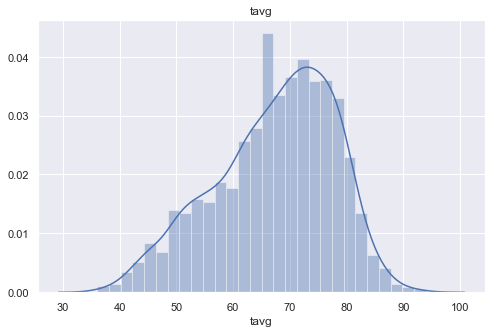

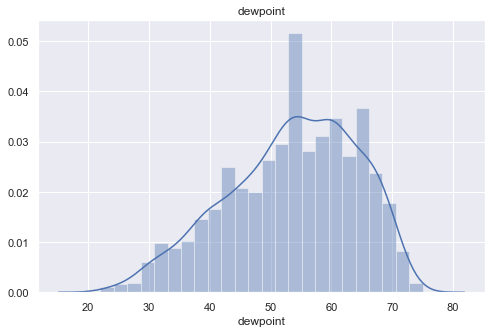

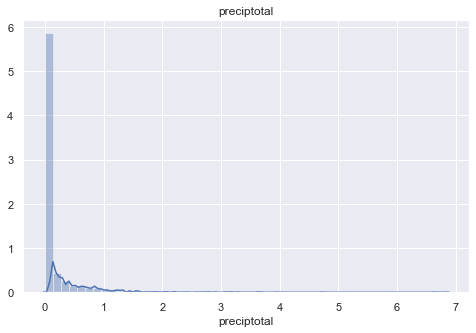

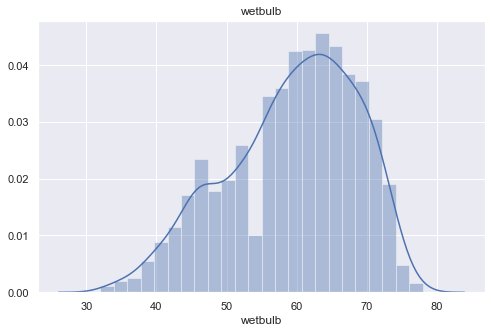

In [52]:
# Plot distribution plots for the columns in weather
for col in ['tavg', 'dewpoint', 'preciptotal', 'wetbulb']:
    plt.figure(figsize=(8,5))
    sns.distplot(weather[col])
    plt.title(col)
    plt.show()

Average temperature, dew point and wet bulb all have left-skewed distributions. The total precipitation shows a mode of 0 with a right-skewed distribution. Next, check for outliers using boxplot. 

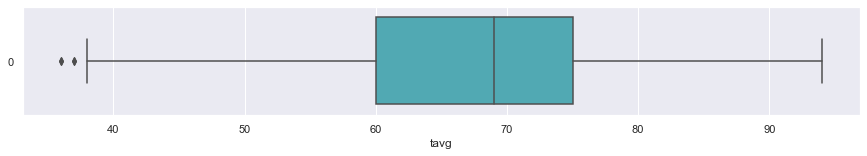

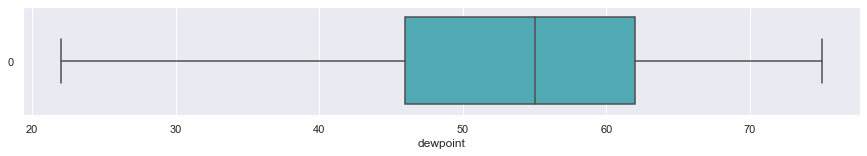

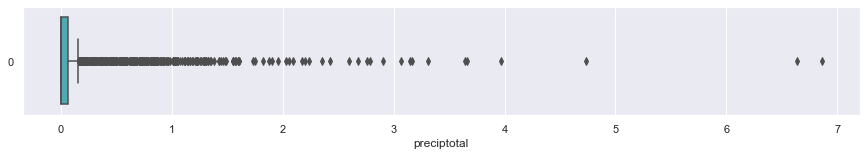

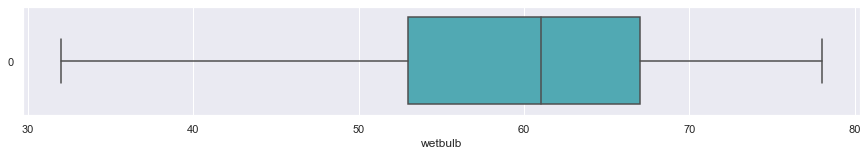

In [53]:
#Plot boxplots to look for outliers
for col in ['tavg', 'dewpoint', 'preciptotal', 'wetbulb']:
    plt.figure(figsize=(15,2))
    plt.xlabel(col)
    sns.boxplot(data=weather[col], orient='h', palette='YlGnBu');

Average temperature has 2 points outside of three standard deviation of the mean but we will leave the data as they are because temperatures do fluctuate unexpectedly sometimes.
As expected, there are many points lying outside of three standard deviation of the mean of total precipitation because of the very large number of 0's in the data. 
On average, there are 189 sunny days per year in Chicago. Chicago gets some kind of precipitation, on average, 125 days per year. Precipitation is rain, snow, sleet, or hail that falls to the ground. In order for precipitation to be counted there has to be at least 0.01 inches on the ground to measure. We will leave the data as it is because it simply indicates that there were many dry days in Chicago at that time. 

#### Analysis of correlations between weather features

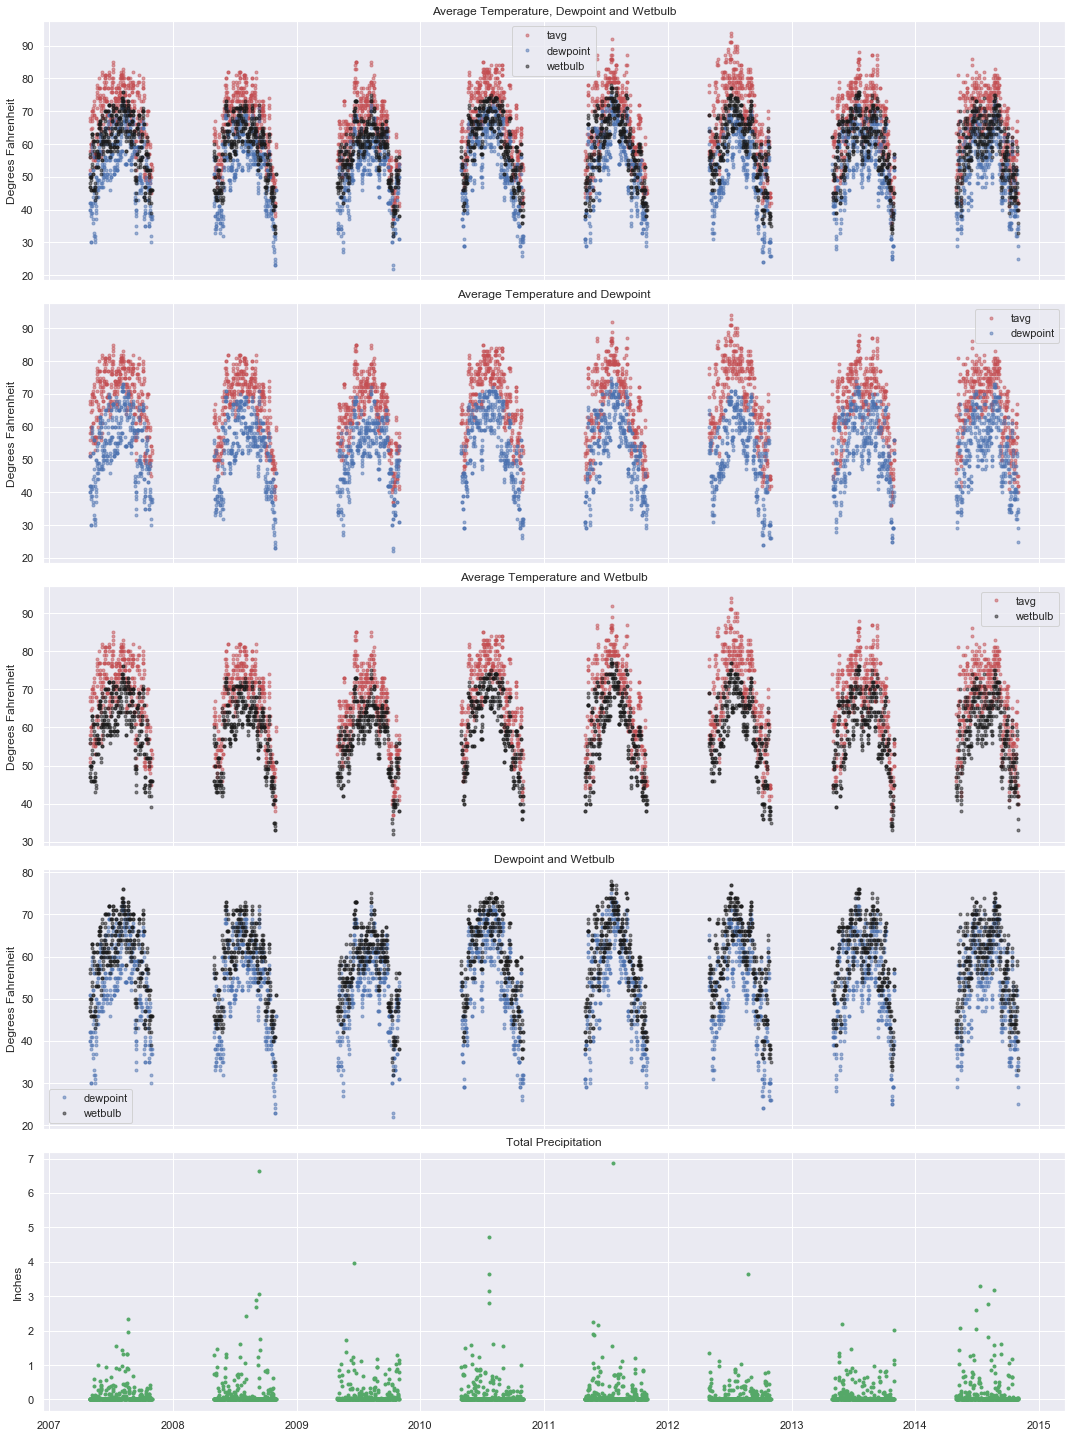

In [54]:
fig, axs = plt.subplots(5, 1, sharex=True, figsize=(15,20))
fig.tight_layout()
# Plot average temperature, dew point and wet bulb
axs[0].plot('date', 'tavg', data=weather, marker='.', linestyle='None', alpha=0.5, color='r')
axs[0].plot('date', 'dewpoint', data=weather, marker='.', linestyle='None', alpha=0.5, color='b')
axs[0].plot('date', 'wetbulb', data=weather, marker='.', linestyle='None', alpha=0.5, color='k')
axs[0].set_ylabel('Degrees Fahrenheit')
axs[0].set_title('Average Temperature, Dewpoint and Wetbulb')
axs[0].legend()

#Plot average temperature and dew point
axs[1].plot('date', 'tavg', data=weather, marker='.', linestyle='None', alpha=0.5, color='r')
axs[1].plot('date', 'dewpoint', data=weather, marker='.', linestyle='None', alpha=0.5, color='b')
axs[1].set_ylabel('Degrees Fahrenheit')
axs[1].set_title('Average Temperature and Dewpoint')
axs[1].legend()

# Plot average temperature and wet bulb
axs[2].plot('date', 'tavg', data=weather, marker='.', linestyle='None', alpha=0.5, color='r')
axs[2].plot('date', 'wetbulb', data=weather, marker='.', linestyle='None', alpha=0.5, color='k')
axs[2].set_ylabel('Degrees Fahrenheit')
axs[2].set_title('Average Temperature and Wetbulb')
axs[2].legend()

# Plot dew point and wet bulb
axs[3].plot('date', 'dewpoint', data=weather, marker='.', linestyle='None', alpha=0.5, color='b')
axs[3].plot('date', 'wetbulb', data=weather, marker='.', linestyle='None', alpha=0.5, color='k')
axs[3].set_ylabel('Degrees Fahrenheit')
axs[3].set_title('Dewpoint and Wetbulb')
axs[3].legend()

# Plot total precipitation
axs[4].plot('date', 'preciptotal', data=weather, marker='.', linestyle='None', color='g')
axs[4].set_ylabel('Inches')
axs[4].set_title('Total Precipitation');

From the plots above, we see that there are overlaps between dew point and wet bulb as well as between average temperature and wet bulb. This may indicate some correlation that we might have to take note of when feature engineering. 
As for average temperature and dew point, there is quite a good separation between the two variables. 

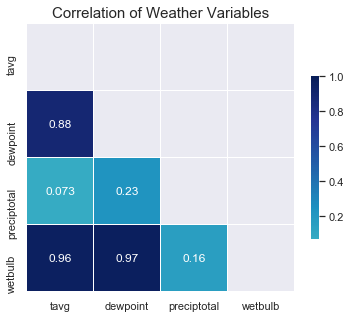

In [55]:
# Plot correlations on a heatmap
fig, ax = plt.subplots(figsize=(6,6))
plt.title('Correlation of Weather Variables', fontsize = 15)
# Generate a mask for the upper triangle (taken from seaborn example gallery)
weather_corr = weather[['tavg', 'dewpoint', 'preciptotal', 'wetbulb']].corr()
mask = np.zeros_like(weather_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(weather_corr, center=0, linewidths=0.5,\
                 square=True, cmap='YlGnBu', annot=True, mask=mask, ax=ax, cbar_kws={"shrink": .5})
bottom,top = ax.get_ylim()
ax.set_ylim(bottom+0.5, top-0.5);
plt.show();

Based on the heatmap above, there appear to be high correlations (>0.9) between the following features:
- Average temperature and wet bulb
- Dewpoint and wetbulb

This indicates that we could combine these features to prevent multicollinearity later on.

### Spray Dataset

In [56]:
basic_eda(spray, 'spray')

SPRAY

Rows: 14835 	 Columns: 4

Total null rows: 584
Percentage null rows: 3.94%

Total duplicate rows: 543
Percentage dupe rows: 3.66%

date         datetime64[ns]
time                 object
latitude            float64
longitude           float64
dtype: object
-----



#### Checking Datatypes

In [57]:
#Checking datatypes
spray.dtypes

date         datetime64[ns]
time                 object
latitude            float64
longitude           float64
dtype: object

In [58]:
spray.head()

,date,time,latitude,longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


#### Identification and removal of duplicate rows

In [59]:
# Check if there are any more duplicate rows
spray[spray.duplicated(keep=False)].shape[0]

543

We note that there are duplicate rows in the training dataset, which need to be removed.

In [60]:
# Determine how many rows exist before removal of the duplicates
spray.shape[0]

14835

In [61]:
spray.drop_duplicates(keep='first', inplace=True)

In [62]:
# Check if there are any more duplicate rows
spray[spray.duplicated(keep=False)].shape[0]

0

In [63]:
# Show how many unique rows remain
spray.shape[0]

14294

#### Checking and Removing Nulls

In [64]:
spray.isnull().sum()

date           0
time         584
latitude       0
longitude      0
dtype: int64

All null rows in this dataset were caused by missing data for 'time'. We are of the view that 'time' data may be too granular for our analysis. Hence we will be dropping the 'time' column from the spray dataset.

In [65]:
spray.drop('time',axis=1, inplace=True)

In [66]:
#Checking that nulls have been removed
spray.isnull().sum()

date         0
latitude     0
longitude    0
dtype: int64

#### Analysis of Spray Locations

We superimpose the locations of the spray locations against the trap locations in the following plot.

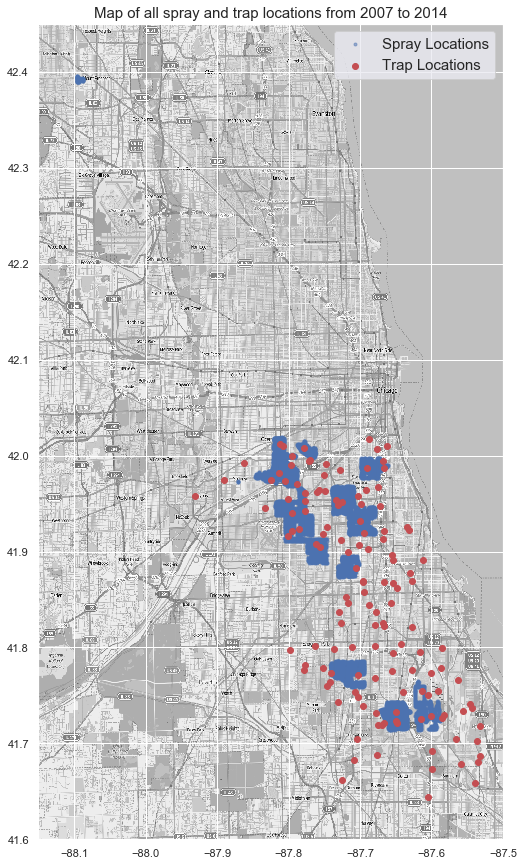

In [67]:
mapdata = np.loadtxt("../assets/mapdata_copyright_openstreetmap_contributors.txt")

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88.15, -87.5, 41.6, 42.45)

plt.figure(figsize=(15,15))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

spray_locations = spray[['longitude', 'latitude']].drop_duplicates().values
plt.scatter(spray_locations[:,0], spray_locations[:,1], marker='.', c="b", alpha=0.5)


trap_locations = train[['longitude', 'latitude']].drop_duplicates().values
plt.scatter(trap_locations[:,0], trap_locations[:,1], marker='o', c='r')

plt.legend(['Spray Locations', 'Trap Locations'], fontsize=15)

plt.title("Map of all spray and trap locations from 2007 to 2014", fontsize=15);

We observe from the above plot that:
- Spray locations are centralised to specific clusters within the area covered by the trap locations.
- There are outliers for the spray locations in the northwest - this corresponds to the O'Hare airport location.

## Data Export

In [68]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9693 entries, 0 to 10505
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    9693 non-null   datetime64[ns]
 1   address                 9693 non-null   object        
 2   species                 9693 non-null   object        
 3   block                   9693 non-null   int64         
 4   street                  9693 non-null   object        
 5   trap                    9693 non-null   object        
 6   addressnumberandstreet  9693 non-null   object        
 7   latitude                9693 non-null   float64       
 8   longitude               9693 non-null   float64       
 9   addressaccuracy         9693 non-null   int64         
 10  nummosquitos            9693 non-null   int64         
 11  wnvpresent              9693 non-null   int64         
 12  month                   9693 non-null   int64  

In [69]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   id                      116293 non-null  int64         
 1   date                    116293 non-null  datetime64[ns]
 2   address                 116293 non-null  object        
 3   species                 116293 non-null  object        
 4   block                   116293 non-null  int64         
 5   street                  116293 non-null  object        
 6   trap                    116293 non-null  object        
 7   addressnumberandstreet  116293 non-null  object        
 8   latitude                116293 non-null  float64       
 9   longitude               116293 non-null  float64       
 10  addressaccuracy         116293 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(5)
memory usage: 9.8+ MB


In [70]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2899 entries, 0 to 2943
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         2899 non-null   datetime64[ns]
 1   tavg         2899 non-null   float64       
 2   dewpoint     2899 non-null   int64         
 3   preciptotal  2899 non-null   float64       
 4   wetbulb      2899 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 215.9 KB


In [71]:
spray.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14294 entries, 0 to 14834
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       14294 non-null  datetime64[ns]
 1   latitude   14294 non-null  float64       
 2   longitude  14294 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 446.7 KB


In [72]:
# Save cleaned datasets for further feature engineering
train.to_csv("../assets/train_clean.csv", index=False)
test.to_csv("../assets/test_clean.csv", index=False)
weather.to_csv("../assets/weather_clean.csv", index=False)
spray.to_csv("../assets/spray_clean.csv", index=False)